# TDT13 Project - Oskar Holm (F2023)

This project is based on the shared task related to Social Media Geolocation (SMG) from VarDial 2020 and 2021, specifically the Workshop on Natural Language Processing (NLP) for Similar Languages, Varieties, and Dialects. Unlike typical VarDial tasks that involve choosing from a set of variety labels, this task focuses on predicting the latitude and longitude from which a social media post was made.

The task remained the same in both 2020 and 2021, covering three language areas: Bosnian-Croatian-Montenegrin-Serbian, German (Germany and Austria), and German-speaking Switzerland. This project is limited to the German-speaking Switzerland area due to time constraints and resource availability.

The goal of the project is to replicate the results of a study that used a BERT-based classifier for this double regression task. The dataset from the 2020 VarDial challenge is chosen because it had more submissions compared to the 2021 dataset. 

## Dependencies and Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json 
from transformers import AdamW
from torch.nn import L1Loss
from tqdm import tqdm

from lib.scalers import scalers
from lib.train_utils import TensorBoardCheckpoint, get_model
from lib.geo import to_projection, GeolocationDataset, transform_to_latlon
from lib.metrics import median_distance, mean_distance
from lib.plotting import plot_switzerland, plot_barchart

data_path = '../data'
vardial_path = '../vardial-shared-tasks/SMG2020'

## Load Config and Datasets

In [3]:
config_name = 'bert-finetuned-swiss-100epoch'

with open('./configs.json', 'r') as f: 
    config = json.load(f)[config_name]

config

{'train_data': 'SMG2020/ch/train.txt',
 'dev_data': 'SMG2020/ch/dev.txt',
 'scaler': 'joint',
 'model_type': 'x-mod',
 'model_name': 'ZurichNLP/swissbert',
 'lossfn': 'MAELoss',
 'save_predictions': True,
 'train_batch_size': 32,
 'max_seq_length': 128,
 'epochs': 50,
 'lr': 2e-05,
 'seed': 42,
 'projection': 'utm',
 'zone_number': 32,
 'zone_letter': 'T'}

In [4]:
train_data = pd.read_table(f'{vardial_path}/ch/train.txt', header=None, names=['lat', 'lon', 'text'])
dev_data = pd.read_table(f'{vardial_path}/ch/dev.txt', header=None, names=['lat', 'lon', 'text'])
test_gold_data = pd.read_table(f'{vardial_path}/ch/test_gold.txt', header=None, names=['lat', 'lon', 'text'])

# Convert to specified projection, if any
train_data, col_names = to_projection(train_data, config)
dev_data, _ = to_projection(dev_data, config)
test_gold_data, _ = to_projection(test_gold_data, config)

scaler = scalers[config['scaler']]()

train_coords = scaler.fit_transform(train_data[col_names[:2]].values)
train_dataset = GeolocationDataset(train_data['text'].tolist(), train_coords, config)
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True)

Path(f'{data_path}/ch').mkdir(exist_ok=True)
with open(f'{data_path}/ch/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

dev_coords = scaler.transform(dev_data[col_names[:2]].values)
dev_dataset = GeolocationDataset(dev_data['text'].tolist(), dev_coords, config)
dev_loader = DataLoader(dev_dataset, batch_size=config['train_batch_size'], shuffle=False)

test_gold_coords = scaler.transform(test_gold_data[col_names[:2]].values)
test_gold_dataset = GeolocationDataset(test_gold_data['text'].tolist(), test_gold_coords, config)
test_gold_loader = DataLoader(test_gold_dataset, batch_size=config['train_batch_size'], shuffle=False)

In [5]:
train_data.head()

,easting,northing,text
0,381131.804856,5.230808e+06,Dr Chester Bennington isch tot 😔😔😔 #rip #linki...
1,439783.213452,5.189910e+06,Mini Fründin hed Lust uf Doktorspieli gha... ....
2,438114.281248,5.248831e+06,Slayer isch besser. Det han ich gescht mini Dr...
3,483390.191173,5.246306e+06,gaht au innere stund? bin grad am speck brate ...
4,427548.501983,5.248952e+06,sie: thy er: ? sie: thy= thank you er: player ...


## Training and Evaluation

### Load Model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
torch.cuda.empty_cache()

model = get_model(config)
optimizer = AdamW(model.parameters(), config['lr'])
model.to(device)

Device: cuda


Some weights of XmodForSequenceClassification were not initialized from the model checkpoint at ZurichNLP/swissbert and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\koholm\dev\TDT13\venv\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


XmodForSequenceClassification(
  (roberta): XmodModel(
    (embeddings): XmodEmbeddings(
      (word_embeddings): Embedding(50262, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XmodEncoder(
      (layer): ModuleList(
        (0-11): 12 x XmodLayer(
          (attention): XmodAttention(
            (self): XmodSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XmodSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(

### Training Loop

In [7]:
loss_function = L1Loss()

tb_checkpoint = TensorBoardCheckpoint(log_dir=f'{data_path}/ch/logs',
                                      checkpoint_path=f'{data_path}/ch/checkpoints', run_name=config_name)

def train(model, train_loader, dev_loader, optimizer, loss_function, scaler, epochs=10):
    loss_function = loss_function.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()

            # Forward pass
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            outputs = model(**inputs)

            # Calculate loss
            loss = loss_function(outputs.logits, labels)
            total_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Training loss: {avg_train_loss:.4f}")

        # Evaluate on dev (validation)
        model.eval()
        dev_preds = []
        dev_labels = []
        with torch.no_grad():
            for batch in tqdm(dev_loader):
                inputs, labels = batch
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)
                outputs = model(**inputs)
                dev_preds.append(outputs.logits.cpu().numpy())
                dev_labels.append(labels.cpu().numpy())

        # Metrics
        dev_preds = np.vstack(dev_preds)
        dev_labels = np.vstack(dev_labels)

        median_dist = median_distance(dev_preds, dev_labels, scaler, config)
        mean_dist = mean_distance(dev_preds, dev_labels, scaler, config)

        metrics = {
            'Loss/train': avg_train_loss, 
            'Median_Distance/dev': median_dist, 
            'Mean_Distance/dev': mean_dist,
        }
        tb_checkpoint.log_metrics(metrics, epoch)
        tb_checkpoint.save_checkpoint(model, optimizer, epoch, metrics, scaler)

with open(f'{data_path}/ch/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

train(model, train_loader, dev_loader, optimizer, loss_function, scaler, epochs=config['epochs'])

tb_checkpoint.close()

100%|██████████| 707/707 [10:12<00:00,  1.15it/s]


Epoch 1/50 - Training loss: 0.6132


100%|██████████| 96/96 [00:45<00:00,  2.12it/s]


New best checkpoint saved at ../data/ch/checkpoints


100%|██████████| 707/707 [10:25<00:00,  1.13it/s]


Epoch 2/50 - Training loss: 0.4808


100%|██████████| 96/96 [00:46<00:00,  2.04it/s]


New best checkpoint saved at ../data/ch/checkpoints


100%|██████████| 707/707 [10:34<00:00,  1.12it/s]


Epoch 3/50 - Training loss: 0.4450


100%|██████████| 96/96 [00:47<00:00,  2.04it/s]


New best checkpoint saved at ../data/ch/checkpoints


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 4/50 - Training loss: 0.4205


100%|██████████| 96/96 [00:47<00:00,  2.04it/s]


New best checkpoint saved at ../data/ch/checkpoints


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 5/50 - Training loss: 0.4028


100%|██████████| 96/96 [00:47<00:00,  2.04it/s]


New best checkpoint saved at ../data/ch/checkpoints


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 6/50 - Training loss: 0.3871


100%|██████████| 96/96 [00:47<00:00,  2.04it/s]


New best checkpoint saved at ../data/ch/checkpoints


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 7/50 - Training loss: 0.3709


100%|██████████| 96/96 [00:47<00:00,  2.04it/s]


New best checkpoint saved at ../data/ch/checkpoints


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 8/50 - Training loss: 0.3582


100%|██████████| 96/96 [00:47<00:00,  2.04it/s]


New best checkpoint saved at ../data/ch/checkpoints


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 9/50 - Training loss: 0.3427


100%|██████████| 96/96 [00:47<00:00,  2.03it/s]


New best checkpoint saved at ../data/ch/checkpoints


100%|██████████| 707/707 [10:34<00:00,  1.12it/s]


Epoch 10/50 - Training loss: 0.3297


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 11/50 - Training loss: 0.3197


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 12/50 - Training loss: 0.3090


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 13/50 - Training loss: 0.2981


100%|██████████| 96/96 [00:47<00:00,  2.01it/s]


New best checkpoint saved at ../data/ch/checkpoints


100%|██████████| 707/707 [10:34<00:00,  1.12it/s]


Epoch 14/50 - Training loss: 0.2897


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 15/50 - Training loss: 0.2807


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 16/50 - Training loss: 0.2710


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 17/50 - Training loss: 0.2631


100%|██████████| 96/96 [00:47<00:00,  2.04it/s]


New best checkpoint saved at ../data/ch/checkpoints


100%|██████████| 707/707 [10:34<00:00,  1.11it/s]


Epoch 18/50 - Training loss: 0.2576


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 19/50 - Training loss: 0.2480


100%|██████████| 707/707 [10:32<00:00,  1.12it/s]


Epoch 20/50 - Training loss: 0.2416


100%|██████████| 707/707 [10:32<00:00,  1.12it/s]


Epoch 21/50 - Training loss: 0.2332


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 22/50 - Training loss: 0.2270


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 23/50 - Training loss: 0.2215


100%|██████████| 707/707 [10:33<00:00,  1.12it/s]


Epoch 24/50 - Training loss: 0.2143


100%|██████████| 707/707 [11:01<00:00,  1.07it/s]


Epoch 25/50 - Training loss: 0.2082


100%|██████████| 707/707 [11:29<00:00,  1.03it/s]


Epoch 26/50 - Training loss: 0.2020


100%|██████████| 707/707 [11:26<00:00,  1.03it/s]


Epoch 27/50 - Training loss: 0.1969


100%|██████████| 707/707 [11:27<00:00,  1.03it/s]


Epoch 28/50 - Training loss: 0.1924


100%|██████████| 707/707 [11:27<00:00,  1.03it/s]


Epoch 29/50 - Training loss: 0.1868


100%|██████████| 707/707 [11:28<00:00,  1.03it/s]


Epoch 30/50 - Training loss: 0.1821


100%|██████████| 707/707 [11:28<00:00,  1.03it/s]


Epoch 31/50 - Training loss: 0.1773


100%|██████████| 707/707 [11:28<00:00,  1.03it/s]


Epoch 32/50 - Training loss: 0.1729


100%|██████████| 707/707 [11:27<00:00,  1.03it/s]


Epoch 33/50 - Training loss: 0.1700


100%|██████████| 707/707 [11:28<00:00,  1.03it/s]


Epoch 34/50 - Training loss: 0.1644


100%|██████████| 707/707 [11:28<00:00,  1.03it/s]


Epoch 35/50 - Training loss: 0.1608


100%|██████████| 707/707 [11:27<00:00,  1.03it/s]


Epoch 36/50 - Training loss: 0.1577


100%|██████████| 707/707 [11:27<00:00,  1.03it/s]


Epoch 37/50 - Training loss: 0.1531


100%|██████████| 707/707 [11:27<00:00,  1.03it/s]


Epoch 38/50 - Training loss: 0.1514


100%|██████████| 707/707 [11:21<00:00,  1.04it/s]


Epoch 39/50 - Training loss: 0.1477


100%|██████████| 96/96 [00:51<00:00,  1.87it/s]


New best checkpoint saved at ../data/ch/checkpoints


100%|██████████| 707/707 [11:22<00:00,  1.04it/s]


Epoch 40/50 - Training loss: 0.1446


100%|██████████| 707/707 [11:24<00:00,  1.03it/s]


Epoch 41/50 - Training loss: 0.1413


100%|██████████| 707/707 [11:23<00:00,  1.03it/s]


Epoch 42/50 - Training loss: 0.1387


100%|██████████| 707/707 [11:26<00:00,  1.03it/s]


Epoch 43/50 - Training loss: 0.1351


100%|██████████| 707/707 [11:23<00:00,  1.03it/s]


Epoch 44/50 - Training loss: 0.1347


 38%|███▊      | 268/707 [04:20<07:06,  1.03it/s]


KeyboardInterrupt: 

### Model Evaluation

In [8]:
def evaluate_geolocation_model_by_checkpoint(checkpoint_dir, checkpoint_file, config):
    torch.cuda.empty_cache()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_model(config)
    
    model.to(device)
    
    checkpoint_path = f'{checkpoint_dir}/{checkpoint_file}'
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    print(checkpoint['metrics'])

    train_data = pd.read_table(f'{vardial_path}/ch/train.txt', header=None, names=['lat', 'lon', 'text'])
    train_data, col_names = to_projection(train_data, config)

    scaler_name = config['scaler']
    checkpoint_scaler = scalers[scaler_name]()
    checkpoint_scaler.fit(train_data[col_names[:2]].values)

    test_gold_data = pd.read_table(f'{vardial_path}/ch/test_gold.txt', header=None, names=['lat', 'lon', 'text'])
    test_gold_data, _ = to_projection(test_gold_data, config)
    test_gold_coords = checkpoint_scaler.transform(test_gold_data[col_names[:2]].values)
    test_gold_dataset = GeolocationDataset(test_gold_data['text'].tolist(), test_gold_coords, config)
    test_gold_loader = DataLoader(test_gold_dataset, batch_size=config['train_batch_size'], shuffle=False)

    model.eval()

    with torch.no_grad():
        test_preds = []
        for batch in tqdm(test_gold_loader):
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            test_preds.append(logits.cpu().numpy())

    test_preds = np.concatenate(test_preds, axis=0)
    print(test_gold_coords.shape, test_preds.shape)

    results = {
        'median_distance': median_distance(test_gold_coords, test_preds, checkpoint_scaler, config),
        'mean_distance': mean_distance(test_gold_coords, test_preds, checkpoint_scaler, config)
    }

    print(f'{checkpoint_file} test results: {results}\n')

    return results, transform_to_latlon(checkpoint_scaler.inverse_transform(test_preds), config)

In [9]:
chkp_dir = f'{data_path}/ch/checkpoints'

with open('./configs.json', 'r') as f:
    configs = json.load(f)

config_names = configs.keys()

best_results = {
    'median_distance': np.inf,
    'mean_distance': np.inf
}

for config_name in config_names:
    chkp_file = f'{config_name}_best_model.pth'
    chkp_config = configs[config_name]

    results, _ = evaluate_geolocation_model_by_checkpoint(
        chkp_dir,
        chkp_file,
        chkp_config,
    )

    if results['median_distance'] < best_results['median_distance']:
        best_checkpoint = chkp_file
        best_results['median_distance'] = results['median_distance']
        best_results['mean_distance'] = results['mean_distance']

print("\nBest Checkpoint:", best_checkpoint)
print("Best Results:", best_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.0759011995221213, 'Median_Distance/dev': 16.61938, 'Mean_Distance/dev': 23.569262}


  0%|          | 0/97 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [10]:
%autoreload 2

with open('./configs.json', 'r') as f:
    configs = json.load(f)

# config_name = '20231107-230346'
# config_name = 'utm_lr2e-5'
# config_name = 'swissbert'

chkp_file = f'{config_name}_best_model.pth'
chkp_config = configs[config_name]

_, test_preds = evaluate_geolocation_model_by_checkpoint(
    chkp_dir,
    chkp_file,
    chkp_config,
)

test_gold_data = pd.read_table(f'{vardial_path}/ch/test_gold.txt', header=None, names=['lat', 'lon', 'text'])

Some weights of XmodForSequenceClassification were not initialized from the model checkpoint at ZurichNLP/swissbert and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.14766582018330882, 'Median_Distance/dev': 17.335152259227044, 'Mean_Distance/dev': 24.722020326080365}


100%|██████████| 97/97 [00:22<00:00,  4.30it/s]

(3097, 2) (3097, 2)
swissbert_best_model.pth test results: {'median_distance': 17.586441083651746, 'mean_distance': 24.471539766289755}



In [ ]:
# import pyproj

# image_extent_lv03 = [574285.0, 573845.0, 162696.0, 162376.0]  
# sw = image_extent_lv03[1], image_extent_lv03[3] 
# ne = image_extent_lv03[0], image_extent_lv03[2] 

# src_crs = pyproj.CRS("EPSG:21781")
# target_crs = pyproj.CRS("EPSG:4326")

# # Create a pyproj Transformer for the conversion
# transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)

# sw = transformer.transform(*sw)
# ne = transformer.transform(*ne)

# image_extent_latlon = sorted([*ne, *sw], reverse=True)
# image_extent_latlon

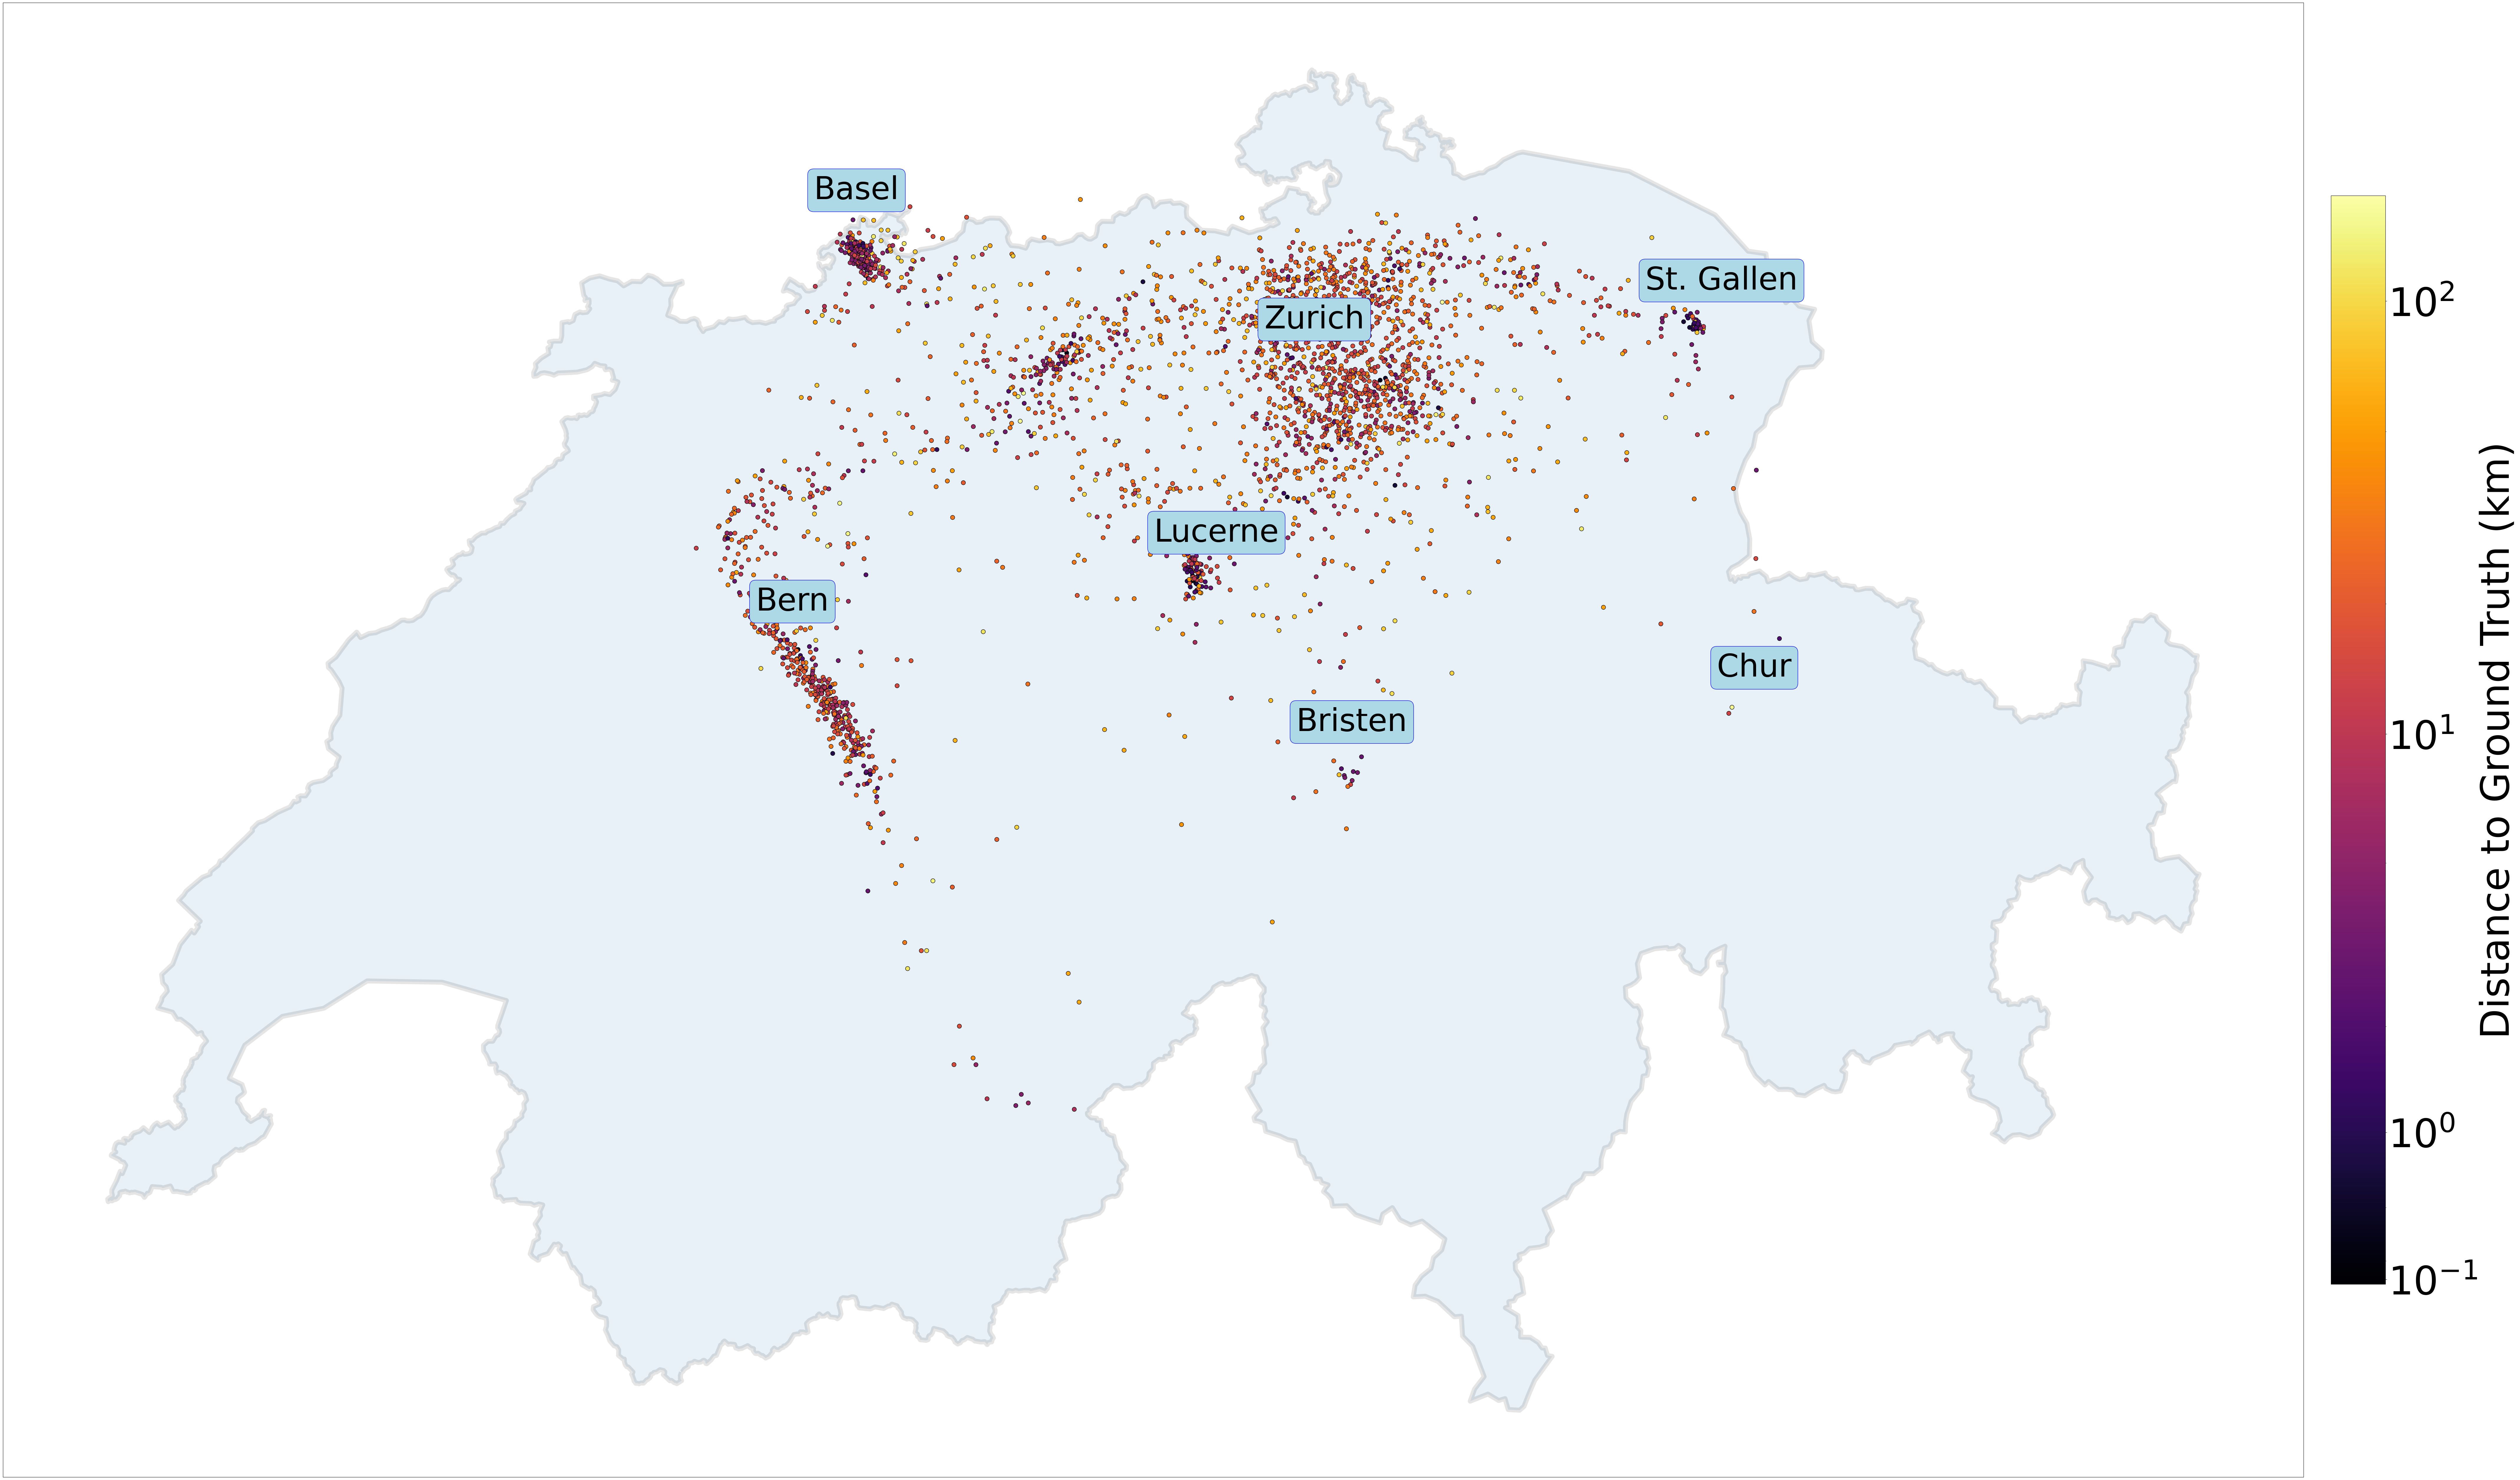

In [11]:
plot_switzerland(test_preds, test_gold_data, data_path)

In [ ]:
plot_barchart(test_preds, test_gold_data)

NameError: name 'predicted_points' is not defined